# Task 1B: Fruit classification with a CNN

This notebook will serve as implementation of the API that you have created in your "Code" folder. You will write functions in the "py" files and use them here.

We will be using "Fruits" dataset present in PyTorch and train a convolutional neural network (CNN) to classify digits.


## What is expected from this notebook?

This notebook should be used to present your work. You should explain wherever necessary (but also not too much) about what you did and why you did it. You should explain things like hyper parameter settings (even if it was provided before hand to you by us), training performance and testing performance of the model. You should reason why your model is working fine and not overfitting.

Since numbers don't are an argot, you should also use visualizations wherever possible. You can visualize things like **loss curve**, show **confusion matrix** and since this is a CNN you can also consider **advance techniques like gradcam**, etc. 

You can also use techniques that allow for faster training, assuage problems involving vanishing and exploding gradients. 

Finally, you can show some manual verifications by displaying and making predictions on random test examples. 

## Absolutely required items?

1. First of all, import the libraries and the dataset. Divide the dataset into test and train.
2. Next, show dataset samples and distribution of different type of data. For example, in case of "Fruits Dataset" you can show some random images and their labels. Also, show distribution of each class of images.
3. Next, perform required transformations (also **data augmentation**) on "Fruits dataset" (normalization, resizing, grayscaling, if required, etc.) using torchvision transforms.
4. Create required dataloaders with PyTorch and use the module dataset we created to load data in mini-batches.
5. Train the model, show loss and accuracy at each step of operation.
6. Plot the **loss curve for both train and validation phase**.
7. Pick some manual random images (probably 7-10) from test dataset and predict their values showing **expected and actual result**. 

**NOTE: ** 
1. You may or may not choose to delete these instruction cells after completion of the notebook.
2. Keep the outputs of the cells.

In [1]:
#Imports
from utils import dataset
import torch.nn as nn
from utils import dataset
import torchvision.transforms as transforms
import torch
import numpy as np
from torch.autograd import Variable
from PIL import Image
import numpy as np
import os
import pandas as pd
from model import FNet
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# import other required libraries here

In [2]:
# loading dataframes using dataset module 
df, df_train, df_test = dataset.create_and_load_meta_csv_df(dataset_path='../Data/fruits/', destination_path='../Data/fruits/', randomize=True, split=0.8)

In [3]:
s1 = np.floor(0.8 * len(df_train)) #conversion as index won't take a float
train_data = df_train.iloc[0:int(s1)]
validation_data = df_train.iloc[int(s1):]
    
#Resetting index so that whole dataframe can be used for iteration
train_data = train_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)
    

In [4]:
# using dataframes, pytorch and torchvision to transform data. Also, use dataloaders for batching, shuffling, etc.  
#Transformation:
#   ToPiLImage :: will convert image to pil image while preserving range of pixels(0 -255)
#   ToTensor   :: will convert every image pixel float number between range 0 -1
   
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),transforms.ToTensor()
    ])
}

image_datasets = {'train': dataset.ImageDataset(df_train, transform=data_transforms['train']), 
                  'val': dataset.ImageDataset(df_test, transform=data_transforms['val']),
                   'test':dataset.ImageDataset(df_test,transform = data_transforms['test']),
                 }

train_dataset = image_datasets['train']
test_dataset = image_datasets['test']
validation_dataset = image_datasets['val']

trainloader = torch.utils.data.DataLoader(dataset=train_dataset ,batch_size =5 ,shuffle = True)
testloader = torch.utils.data.DataLoader(dataset=test_dataset ,batch_size =1 ,shuffle = False)
validationloader = torch.utils.data.DataLoader(dataset=validation_dataset ,batch_size =1 ,shuffle = True)

# Visualising Training data

Strawberry


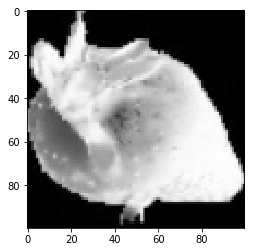

Banana


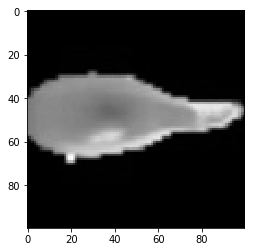

Banana


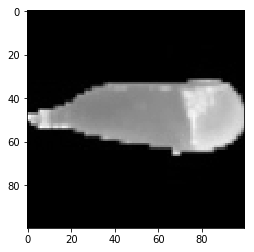

In [5]:
random_generated_number = torch.LongTensor(1).random_(0,(train_dataset.data.shape[0]))
plt.imshow((trainloader.dataset[random_generated_number.numpy()[0]][0]).reshape(100,100),cmap="gray")
print(train_dataset.classes[trainloader.dataset[random_generated_number.numpy()[0]][1]])
plt.show()
random_generated_number = torch.LongTensor(1).random_(0,(train_dataset.data.shape[0]))
plt.imshow((trainloader.dataset[random_generated_number.numpy()[0]][0]).reshape(100,100),cmap="gray")
print(train_dataset.classes[trainloader.dataset[random_generated_number.numpy()[0]][1]])

plt.show()
random_generated_number = torch.LongTensor(1).random_(0,(train_dataset.data.shape[0]))
plt.imshow((trainloader.dataset[random_generated_number.numpy()[0]][0]).reshape(100,100),cmap="gray")
print(train_dataset.classes[trainloader.dataset[random_generated_number.numpy()[0]][1]])


We will use gray scale "1" channel as it will help us speed up process instead of doing it on "3" channels. 
But during visulazation we will use 3 channels for color image display

# Defining our neural netwok model

In [6]:
#temprory variables to store data and labels 
data = []
labels = torch.FloatTensor()
inputs = torch.FloatTensor()
valid_loss = []
train_loss = []

In [7]:
def make_trainloader(train_dataset,test_dataset,validation_dataset,train_batch_size,test_batch_size):
    """This funtion will create iterable dataloaders for dataset
       Args:
           Self explainatory 
       Return:
           training set data loader , validation set dataloader and testset dataloader
    """
    trainloader = torch.utils.data.DataLoader(dataset=train_dataset ,batch_size =train_batch_size ,shuffle = True)
    testloader = torch.utils.data.DataLoader(dataset=test_dataset ,batch_size =test_batch_size ,shuffle = True)
    validationloader = torch.utils.data.DataLoader(dataset=validation_dataset ,batch_size =test_batch_size ,shuffle = True)
    
    return trainloader,testloader,validationloader


# We will push variables to gpu is available using .cuda()
Only the model and variables will be pushed to gpu

In [8]:
def forward_backprop(cost_fn,optimizer,model,inputs,labels,learning_rate):
            """This funtion will perforn forward pass and backward pass
               Args:
                   model: neural network model
                   inputs : dataset
                   labels : targets
                   laerning_rate : hyperparameter
               Return:
                   model : trained model (Single iteration), this model will be further used for validation.
                   temp_out : output from forward pass
                   loss : loss calculated from loss funtion
                   
            """
           
            #Taking out a temprary output from model's forward pass
            temp_out = model(inputs)
            #Resetting the current gradients for new gradients calculation
            optimizer.zero_grad()
            
            loss = cost_fn(temp_out , labels.type(torch.LongTensor))
            #back prop
            loss.backward()
            
            #Updating parameters
            optimizer.step()
            return model,temp_out,loss


In [9]:

def training_accuracy(temp_out,labels,loss):
    """Computes training accuracy and loss"""
    total1=0
    correct1=0
    _,pred = torch.max(temp_out,1)
    total1 += labels.size(0)
    if not torch.cuda.is_available():
        correct1+= ((pred.type(torch.FloatTensor)).cpu() == labels.cpu()).sum()
        
    else:
        correct1+= (pred.type(torch.FloatTensor) == labels).sum()
        #Average accuracy        
        acc1 = 100 * correct1/total1
        print('Training loss is ',loss.data[0],'Training accuracy is ',acc1[0],'%')

def validating(model,validationloader,cost_fn):
    """Computes accuracy and loss of validation set"""
    correct = 0
    total = 0
    for batch_idx1 , dat1 in enumerate(validationloader):
        data1 = dat1
        inputs1 = data1[0].type(torch.FloatTensor)
        labels1 = data1[1].type(torch.FloatTensor)
        if not torch.cuda.is_available():
            inputs1 = Variable(inputs1.cuda())
        else:
            inputs1 = Variable(inputs1)
            
        temp_out1 = model(inputs1)
        loss1 = cost_fn(temp_out1 , labels1.type(torch.LongTensor))
        valid_loss.append(loss1.data[0])
        _,pred = torch.max(temp_out1,1)
        total += labels1.size(0)
        if not torch.cuda.is_available():
            correct+= ((pred.type(torch.FloatTensor)).cpu() == labels1.cpu()).sum()
            
        else:
            correct+= (pred.type(torch.FloatTensor) == labels1).sum()
            
    acc = 100 * correct/total
    print('Loss on valdation set ',loss1.data[0],'  Accuracy ',acc[0],'%',)
    


initialize model with hyper parameters

in_channel = 1 as image was converted to gray scale

kernel are for filter size

outchannels are for total number for kernels stack

Stride has been set to 1
    

In [10]:
model = FNet(in_channel=1,out_channels1=16,out_channels2=32,kernel1=5,pool_kernel=2,stride=1)
if not torch.cuda.is_available():
    model.cuda()
    

In [11]:
n_epochs  = 3
cost_fn = nn.CrossEntropyLoss()
learning_rate = 0.01
    

We used Adam optimizer of SGD, as it will handle out the both exploding and vanishing gradient, the algorithm is designed 
from ada grad algorithm but optimised for non convex funtion as the baises corrections are introduced we should not worry about saddle gradients.
We set the weight decay for L2 norm
    

In [12]:
optimizer  = torch.optim.Adam(model.parameters() , lr  = learning_rate,weight_decay=1e-4)

In [13]:
#Parameter to decide wheather to print training loss on every iteration not
debug = False
#Parameter to decide wheather to save model after training or not
save =False

# Training our models

In [14]:
for epochs in range(n_epochs):
        for batch_idx , dat in enumerate(trainloader):
            data = dat
            inputs = data[0].type(torch.FloatTensor)
            labels = data[1].type(torch.FloatTensor)
            if not torch.cuda.is_available():
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:    
                inputs = Variable(inputs)
                labels = Variable(labels)
            
            model,temp_out,loss =  forward_backprop(cost_fn,optimizer,model,inputs,labels,learning_rate)
            train_loss.append(loss.data[0])
            if (debug==True):
                training_accuracy(temp_out,labels,loss)
                
        #This validation set will be tested after each epoch        
        validating(model,validationloader,cost_fn)

Loss on valdation set  tensor(0.0000)   Accuracy  tensor(97) %
Loss on valdation set  tensor(0.0000)   Accuracy  tensor(99) %
Loss on valdation set  tensor(9.5367e-07)   Accuracy  tensor(99) %


In [15]:
def test_mode(data,model):
     """Testing model on new data that the model have not seen  before
        Args:
            data: test data
            model : trained model
     """
     correct = 0
     total = 0
     for batch_idx1 , dat1 in enumerate(data):
                    data1 = dat1
                    inputs1 = data1[0].type(torch.FloatTensor)
                    labels1 = data1[1].type(torch.FloatTensor)
                    #GPU CHECK
                    if not torch.cuda.is_available():
                        inputs1 = Variable(inputs1.cuda())
                    else:
                        inputs1 = Variable(inputs1)
                    
                    temp_out1 = model(inputs1)
                    
                    _,pred = torch.max(temp_out1,1)
                    total += labels1.size(0)
                    if not torch.cuda.is_available():
                        correct+= ((pred.type(torch.FloatTensor)).cpu() == labels1.cpu()).sum()
                        
                    else:
                        correct+= (pred.type(torch.FloatTensor) == labels1).sum()
     #AVERAGE ACCURACY               
     acc = 100 * correct/total
     print('Accuracy of model on new unseen data is ',acc,'%')


In [16]:
from sklearn.metrics import confusion_matrix,classification_report


def test_confusion_matrix(data,model):
     """ this funtion will make prediction on test dataset and return predicted and true labels
        Args:
            data: test data
            model : trained model
     """
     y_pred  = []
     y_true  = []
     for batch_idx1 , dat1 in enumerate(data):
                    data1 = dat1
                    inputs1 = data1[0].type(torch.FloatTensor)
                    labels1 = data1[1].type(torch.FloatTensor)
                    #GPU CHECK
                    if not torch.cuda.is_available():
                        inputs1 = Variable(inputs1.cuda())
                    else:
                        inputs1 = Variable(inputs1)
                    
                    temp_out1 = model(inputs1)
                    
                    _,pred = torch.max(temp_out1,1)
                    y_pred.append(pred)
                    y_true.append(labels1)
     return y_pred,y_true

y_hat , y = test_confusion_matrix(testloader,model)

In [17]:
print( confusion_matrix( y_true = y,y_pred = y_hat) ,end = '\n\n\n')
print( classification_report( torch.tensor(y),torch.tensor(y_hat) ))


[[106   0   0   0   0]
 [  4  82   0   0   0]
 [  0   0  95   0   0]
 [  0   0   0  98   0]
 [  0   0   0   0 104]]


             precision    recall  f1-score   support

        0.0       0.96      1.00      0.98       106
        1.0       1.00      0.95      0.98        86
        2.0       1.00      1.00      1.00        95
        3.0       1.00      1.00      1.00        98
        4.0       1.00      1.00      1.00       104

avg / total       0.99      0.99      0.99       489



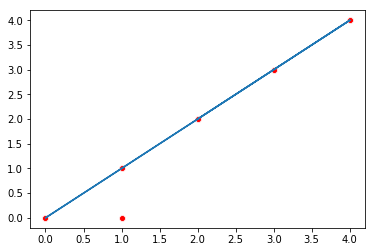

In [18]:
sns.scatterplot(y,y_hat,color='red',markers='X')
plt.plot(y,y)

From the confusion matrix we can see that there was only 4 mislabled datas in test dataset out of 489 , that was actually one label which should be of category 1 but was marked as category 0 , thats a 0.817% error rate , rather than that we have a great classifier model.

Note: this conclusion was generated during our run , values will change when the model is trained again.

# Visualising Losses

Text(0.5,1,'Training loss')

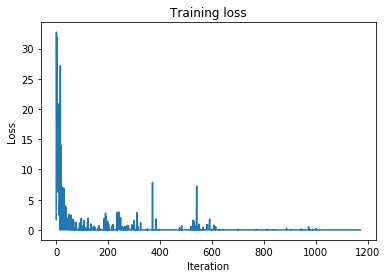

In [19]:
plt.plot(range(len(train_loss)) , train_loss )
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training loss")

Spikes in training loss is decreasing that tell us that our model was fitted well to training data

Text(0.5,1,'Validation loss')

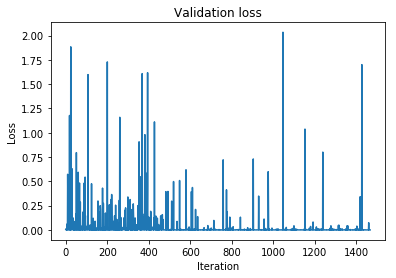

In [20]:
plt.plot(range(len(valid_loss)) , valid_loss )
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Validation loss")

Spikes in validation loss is decreasing that tell us that our model was not overfitted to training data.

In [21]:
#Saving whole model    
if(save == True):
    torch.save(model,f = 'model_beta.pt')
#Testing model on new test data
test_mode(testloader,model)
    

Accuracy of model on new unseen data is  tensor(99) %


# Visualizing test set on model

Now we will pick seven random images from test set as it is not seen by model.
We will first plot the image, then display corresponding class.
Then we will pass the pixels of the image we got from random selection in test set to our model,our model will output a vector
of proabablity and then we will take the index of maximum probablity and use that as model's prediction to that image.

Expected : Banana
Actual result:  Banana


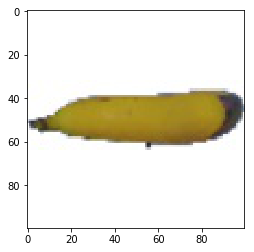

In [22]:
"""Random number generation"""
random_generated_number = torch.LongTensor(1).random_(0,(test_dataset.data.shape[0]))

"""We use the random number as index in test set and display corresponding image"""
temp_path = test_dataset.data['path'][random_generated_number]
img = Image.open(temp_path)
plt.imshow(img)

"""We extract the pixel from corresponding image and pass it to model for forward propogation"""
temp_pixel  = testloader.dataset[random_generated_number.numpy()[0]][0]
temp_out = model(temp_pixel.reshape(1,1,100,100))

"""We convert probablity to a single prediction, where the prediction will be the class index Example 0 for apple"""
idx = torch.argmax(temp_out)

"""Displaying result"""
print('Expected :',(test_dataset.classes[testloader.dataset[random_generated_number.numpy()[0]][1]]))
print('Actual result: ',test_dataset.classes[idx])

Expected : Strawberry
Actual result:  Strawberry


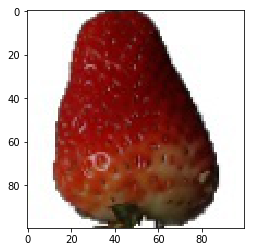

In [23]:
"""Random number generation"""
random_generated_number = torch.LongTensor(1).random_(0,(test_dataset.data.shape[0]))

"""We use the random number as index in test set and display corresponding image"""
temp_path = test_dataset.data['path'][random_generated_number]
img = Image.open(temp_path)
plt.imshow(img)

"""We extract the pixel from corresponding image and pass it to model for forward propogation"""
temp_pixel  = testloader.dataset[random_generated_number.numpy()[0]][0]
temp_out = model(temp_pixel.reshape(1,1,100,100))

"""We convert probablity to a single prediction, where the prediction will be the class index Example 0 for apple"""
idx = torch.argmax(temp_out)

"""Displaying result"""
print('Expected :',(test_dataset.classes[testloader.dataset[random_generated_number.numpy()[0]][1]]))
print('Actual result: ',test_dataset.classes[idx])

Expected : Strawberry
Actual result:  Strawberry


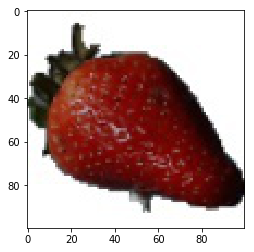

In [24]:
"""Random number generation"""
random_generated_number = torch.LongTensor(1).random_(0,(test_dataset.data.shape[0]))

"""We use the random number as index in test set and display corresponding image"""
temp_path = test_dataset.data['path'][random_generated_number]
img = Image.open(temp_path)
plt.imshow(img)

"""We extract the pixel from corresponding image and pass it to model for forward propogation"""
temp_pixel  = testloader.dataset[random_generated_number.numpy()[0]][0]
temp_out = model(temp_pixel.reshape(1,1,100,100))

"""We convert probablity to a single prediction, where the prediction will be the class index Example 0 for apple"""
idx = torch.argmax(temp_out)

"""Displaying result"""
print('Expected :',(test_dataset.classes[testloader.dataset[random_generated_number.numpy()[0]][1]]))
print('Actual result: ',test_dataset.classes[idx])

Expected : Pineapple
Actual result:  Pineapple


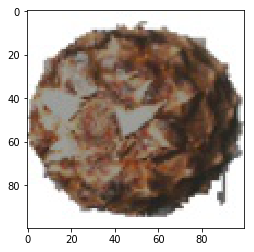

In [25]:
"""Random number generation"""
random_generated_number = torch.LongTensor(1).random_(0,(test_dataset.data.shape[0]))

"""We use the random number as index in test set and display corresponding image"""
temp_path = test_dataset.data['path'][random_generated_number]
img = Image.open(temp_path)
plt.imshow(img)

"""We extract the pixel from corresponding image and pass it to model for forward propogation"""
temp_pixel  = testloader.dataset[random_generated_number.numpy()[0]][0]
temp_out = model(temp_pixel.reshape(1,1,100,100))

"""We convert probablity to a single prediction, where the prediction will be the class index Example 0 for apple"""
idx = torch.argmax(temp_out)

"""Displaying result"""
print('Expected :',(test_dataset.classes[testloader.dataset[random_generated_number.numpy()[0]][1]]))
print('Actual result: ',test_dataset.classes[idx])

Expected : Pineapple
Actual result:  Pineapple


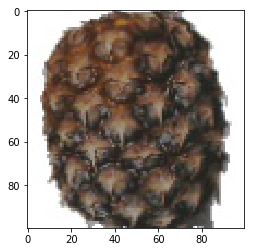

In [26]:
"""Random number generation"""
random_generated_number = torch.LongTensor(1).random_(0,(test_dataset.data.shape[0]))

"""We use the random number as index in test set and display corresponding image"""
temp_path = test_dataset.data['path'][random_generated_number]
img = Image.open(temp_path)
plt.imshow(img)

"""We extract the pixel from corresponding image and pass it to model for forward propogation"""
temp_pixel  = testloader.dataset[random_generated_number.numpy()[0]][0]
temp_out = model(temp_pixel.reshape(1,1,100,100))

"""We convert probablity to a single prediction, where the prediction will be the class index Example 0 for apple"""
idx = torch.argmax(temp_out)

"""Displaying result"""
print('Expected :',(test_dataset.classes[testloader.dataset[random_generated_number.numpy()[0]][1]]))
print('Actual result: ',test_dataset.classes[idx])

Expected : Apple
Actual result:  Apple


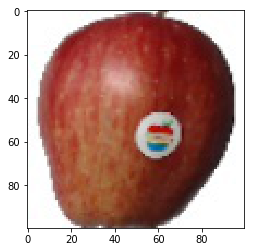

In [27]:
"""Random number generation"""
random_generated_number = torch.LongTensor(1).random_(0,(test_dataset.data.shape[0]))

"""We use the random number as index in test set and display corresponding image"""
temp_path = test_dataset.data['path'][random_generated_number]
img = Image.open(temp_path)
plt.imshow(img)

"""We extract the pixel from corresponding image and pass it to model for forward propogation"""
temp_pixel  = testloader.dataset[random_generated_number.numpy()[0]][0]
temp_out = model(temp_pixel.reshape(1,1,100,100))

"""We convert probablity to a single prediction, where the prediction will be the class index Example 0 for apple"""
idx = torch.argmax(temp_out)

"""Displaying result"""
print('Expected :',(test_dataset.classes[testloader.dataset[random_generated_number.numpy()[0]][1]]))
print('Actual result: ',test_dataset.classes[idx])

Expected : Strawberry
Actual result:  Strawberry


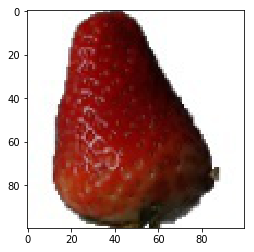

In [28]:
"""Random number generation"""
random_generated_number = torch.LongTensor(1).random_(0,(test_dataset.data.shape[0]))

"""We use the random number as index in test set and display corresponding image"""
temp_path = test_dataset.data['path'][random_generated_number]
img = Image.open(temp_path)
plt.imshow(img)

"""We extract the pixel from corresponding image and pass it to model for forward propogation"""
temp_pixel  = testloader.dataset[random_generated_number.numpy()[0]][0]
temp_out = model(temp_pixel.reshape(1,1,100,100))

"""We convert probablity to a single prediction, where the prediction will be the class index like 0 for apple"""
idx = torch.argmax(temp_out)

"""Displaying result"""
print('Expected :',(test_dataset.classes[testloader.dataset[random_generated_number.numpy()[0]][1]]))
print('Actual result: ',test_dataset.classes[idx])

Expected : Pineapple
Actual result:  Pineapple


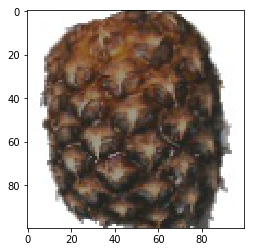

In [29]:
"""Random number generation"""
random_generated_number = torch.LongTensor(1).random_(0,(test_dataset.data.shape[0]))

"""We use the random number as index in test set and display corresponding image"""
temp_path = test_dataset.data['path'][random_generated_number]
img = Image.open(temp_path)
plt.imshow(img)

"""We extract the pixel from corresponding image and pass it to model for forward propogation"""
temp_pixel  = testloader.dataset[random_generated_number.numpy()[0]][0]
temp_out = model(temp_pixel.reshape(1,1,100,100))

"""We convert probablity to a single prediction, where the prediction will be the class index Example 0 for apple"""
idx = torch.argmax(temp_out)

"""Displaying result"""
print('Expected :',(test_dataset.classes[testloader.dataset[random_generated_number.numpy()[0]][1]]))
print('Actual result: ',test_dataset.classes[idx])

# Now lets visulize what going inside the cnn

Lets pic up a image

In [30]:
img = Image.open("17_100.jpg")

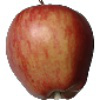

In [31]:
img

In [32]:
#Convert it to pixels in grayscale
width, height = img.size
img_color = img.convert('L')
img_h = img_color.size[1]
img_b = img_color.size[0]
#Getting pixel values from image 
value = np.asarray(img_color.getdata(), dtype=np.int).reshape((1,img_color.size[1], img_color.size[0]))

value = torch.tensor(value)

In [33]:
#Let's apply some transforms
pil = transforms.ToPILImage()
tT = transforms.ToTensor()
value = pil(value.type(torch.FloatTensor))
value = tT(value)

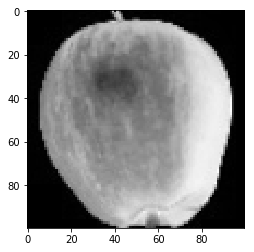

In [34]:
#Original image after transforms
plt.imshow(value.reshape(100,100),cmap="gray")

In [35]:
"""Now as we have a trained model we will create some temperory variables that stores the outputs of the processed image,
at each step within cnn"""

temp_out_cnn1 = model.cnn1(torch.tensor(value).reshape(1,1,100,100).type(torch.FloatTensor))
temp_out_batch1 = model.batch1(temp_out_cnn1)
temp_out_relu1 = model.relu1(temp_out_batch1)

temp_out_max1 = model.maxpool1(temp_out_relu1)

temp_out_cnn2 = model.cnn2(temp_out_max1)
temp_out_batch2 = model.batch2(temp_out_cnn2)
temp_out_relu2 = model.relu2(temp_out_batch2)

temp_out_max2 = model.maxpool2(temp_out_relu2)

In [36]:
#Now lets remove grads from variables
temp_out_cnn1 = temp_out_cnn1.detach().numpy().reshape(16,100,100)
temp_out_cnn2 = temp_out_cnn2.detach().numpy().reshape(32,50,50)
temp_out_max1 = temp_out_max1.detach().numpy().reshape(16,50,50)
temp_out_max2 = temp_out_max2.detach().numpy().reshape(32,25,25)
temp_out_relu1 = temp_out_relu1.detach().numpy().reshape(16,100,100)
temp_out_relu2 = temp_out_relu2.detach().numpy().reshape(32,50,50)

Now let' visualize whats going on in first convulution layer

<Figure size 432x288 with 0 Axes>

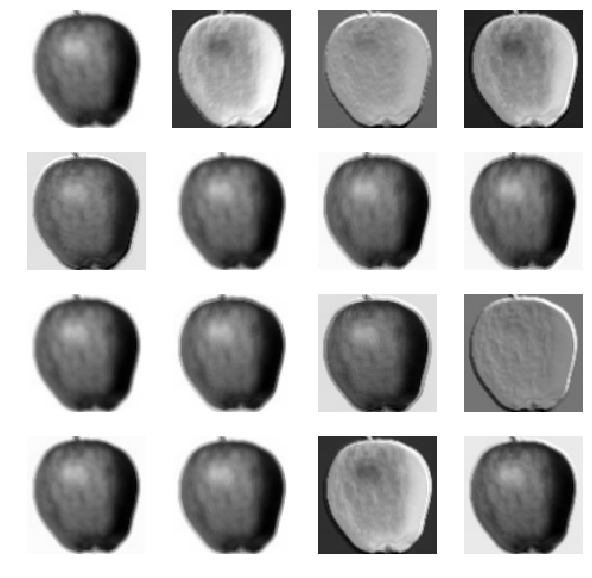

In [37]:
figure = plt.figure()
plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4,4, i + 1)
    plt.imshow(temp_out_cnn1[i].reshape(100,100),cmap="gray")
    plt.axis('off')
figure.show()

This are the feature maps of 16 kernels from first cnn,
We can we the first cnn layer focus more on outer shape of the fruit, we can say out kernel size is appropriate to capture shape details.
As we increase the kernel size the more info we lose information so we decided to stick with 3.

# Lets add an activation layer 

<Figure size 432x288 with 0 Axes>

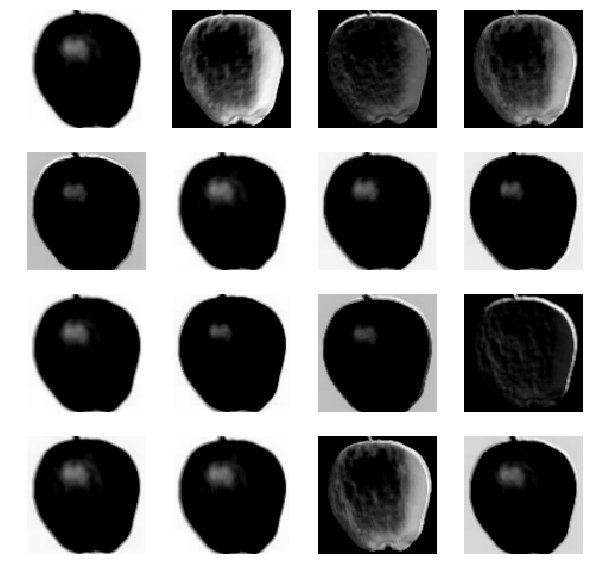

In [38]:
figure = plt.figure()
plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4,4, i + 1)
    plt.imshow(temp_out_relu1[i].reshape(100,100),cmap="gray")
    plt.axis('off')
figure.show()

We got rid of most of the noise by adding relu.
Lets assume this grid is a 4X4 matrix so we can visulaize easily, the image[1][3] shows that the that neuron mostly will look for shadows.
matrix [1][2] , [2][2] and [3][2] agains catches shapes, and more over we can see it is easy for this matrixes to catch shapes than the previous grid.

# Lets add a pooling layer 

<Figure size 432x288 with 0 Axes>

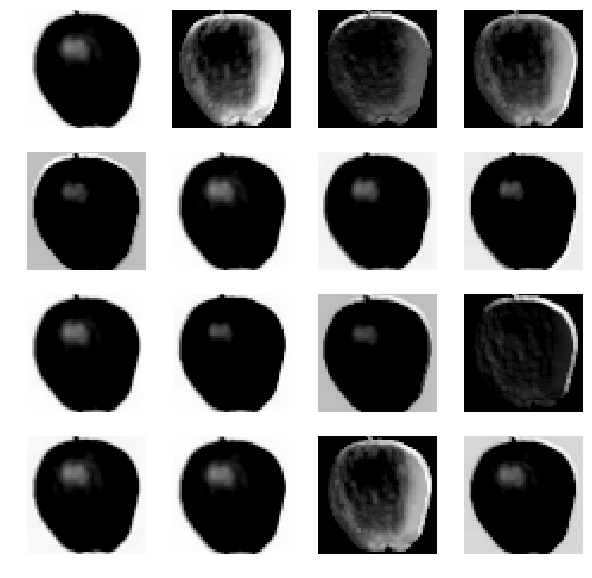

In [39]:
figure = plt.figure()
plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4,4, i + 1)
    plt.imshow(temp_out_max1[i].reshape(50,50),cmap="gray")
    plt.axis('off')
figure.show()

The maxpool blurs the image as too reduce dimentions, the image is now about half it's original size.

# Let's add another layer

<Figure size 432x288 with 0 Axes>

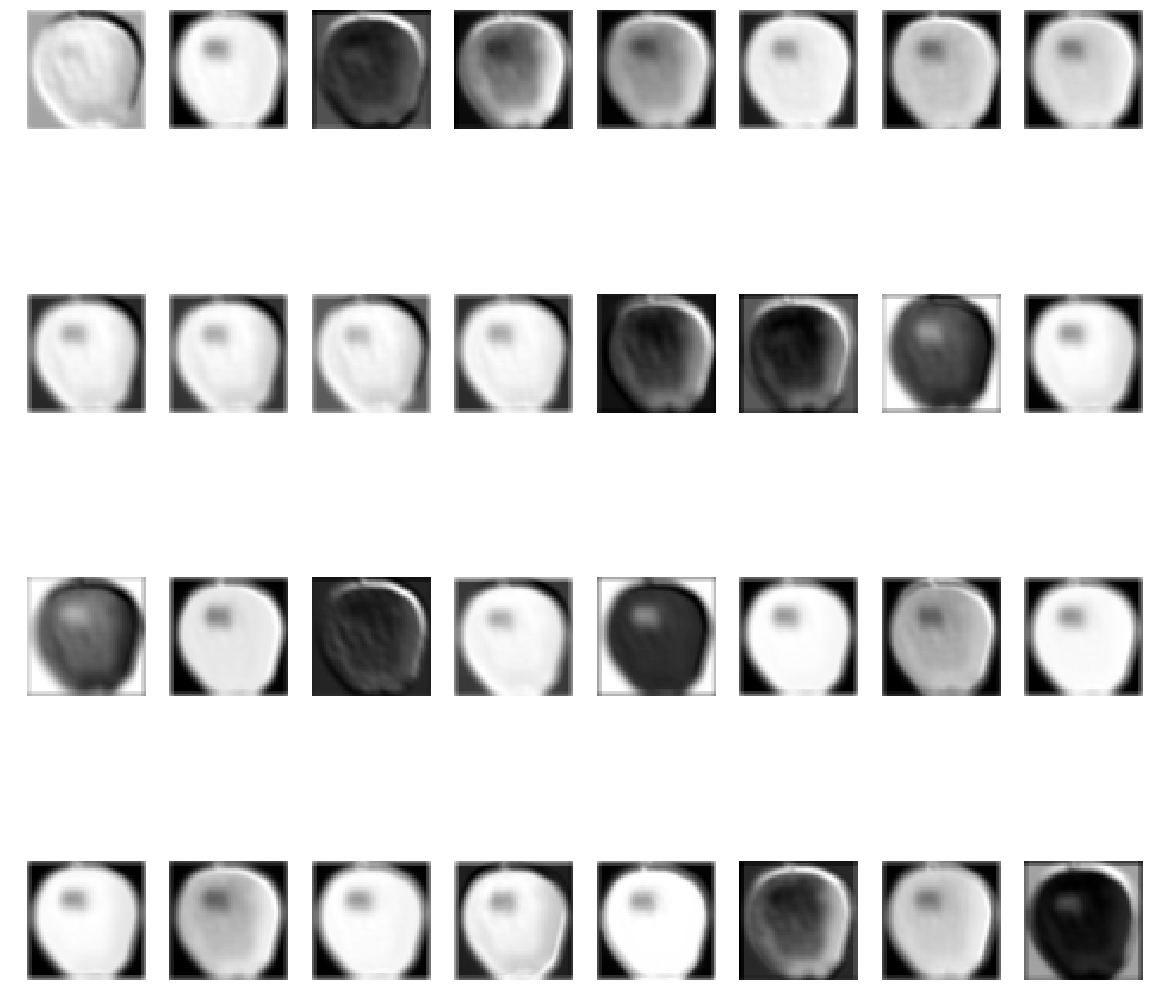

In [40]:
figure = plt.figure()
plt.figure(figsize=(20,20))

for i in range(32):
    plt.subplot(4,8, i + 1)
    plt.imshow(temp_out_cnn2[i].reshape(50,50),cmap="gray")
    plt.axis('off')
figure.show()

Now the blurred image passes to cnn layer 2 with 32 filters and this layer is mostly looking for edges as the feature (row 1 and row 4).

# let's add another relu

<Figure size 432x288 with 0 Axes>

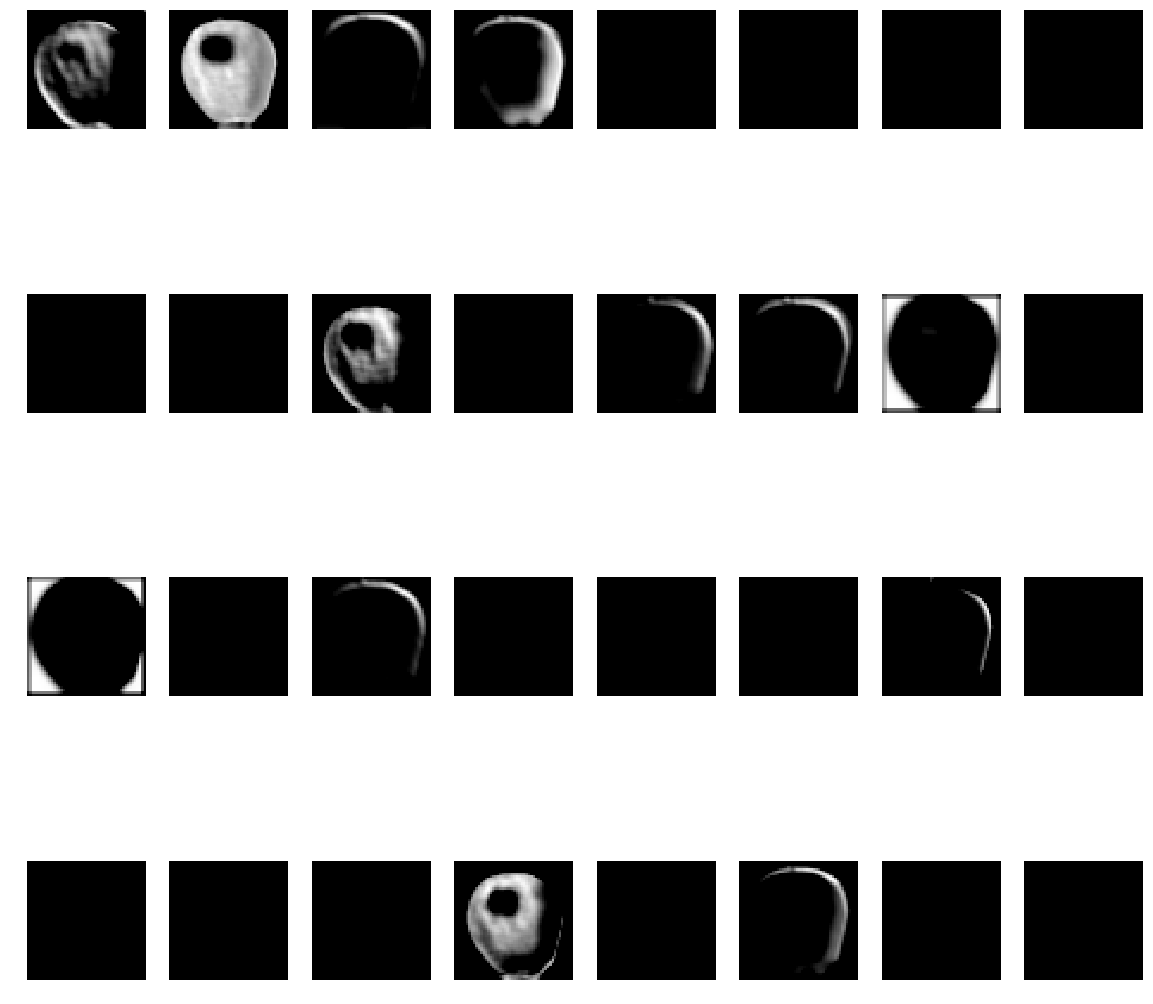

In [41]:
figure = plt.figure()
plt.figure(figsize=(20,20))

for i in range(32):
    plt.subplot(4,8, i + 1)
    plt.imshow(temp_out_relu2[i].reshape(50,50),cmap="gray")
    plt.axis('off')
figure.show()

This layer just pull off the remaining noise and greatly catches shape and edge E.g:matrix[1][6], unless some matrix which are fully blackout.

# Let's finalise by adding maxpool layer 

<Figure size 432x288 with 0 Axes>

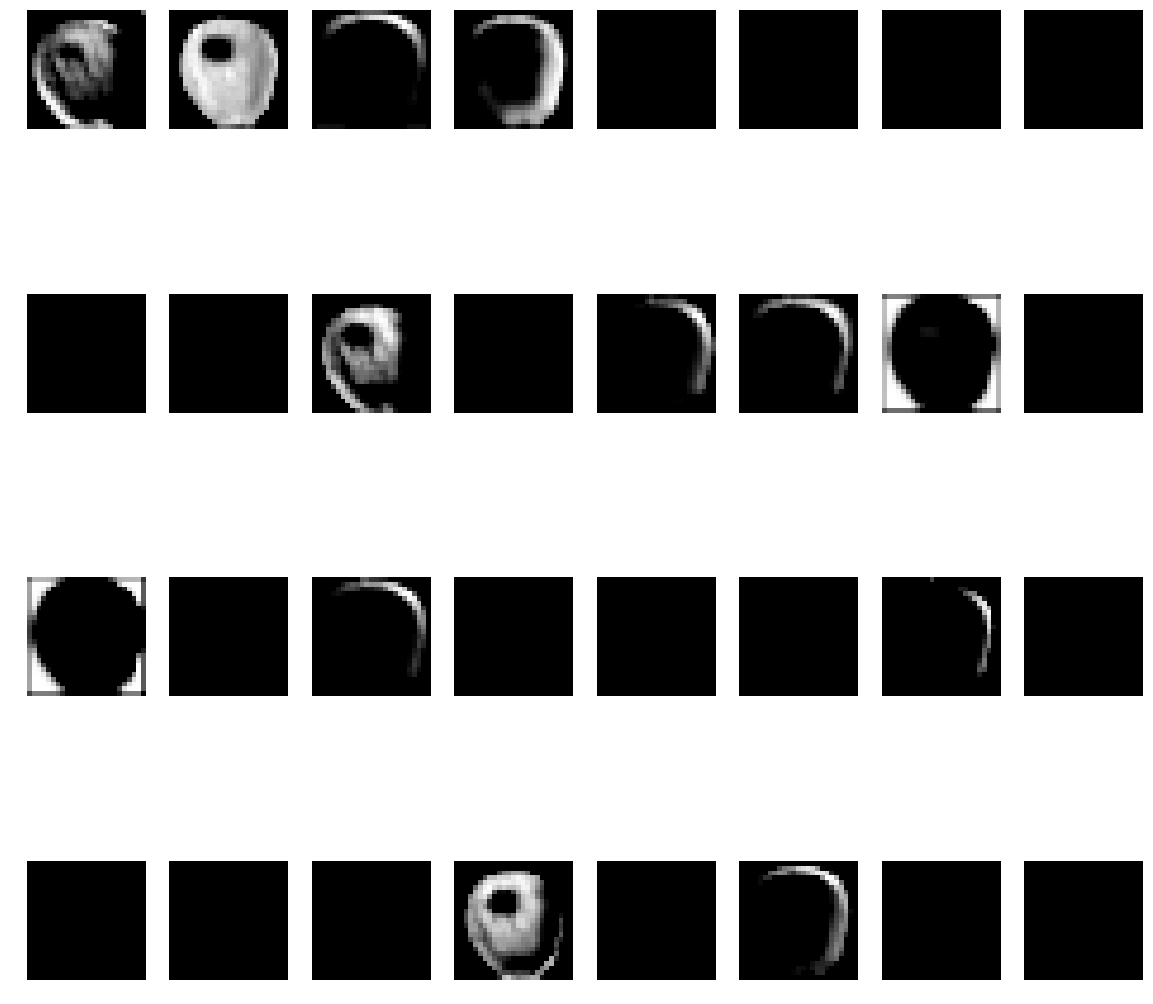

In [42]:
figure = plt.figure()
plt.figure(figsize=(20,20))

for i in range(32):
    plt.subplot(4,8, i + 1)
    plt.imshow(temp_out_max2[i].reshape(25,25),cmap="gray")
    plt.axis('off')
figure.show()

The image size is now reduced to quater of original image, this images are supplied to fully connected layer for forward props.